Bayesian-Temporal Correlated Equilibrium Simulation
(PAPER-ALIGNED: Type Evolution + Phase-Driven Strategy)

✓ Loaded 40 policies defining 10 signal channels
  Channels: ['s_logon_time', 's_logon_breadth', 's_role_change', 's_context_shift', 's_device_vol', 's_email_vol', 's_http_exfil', 's_file_sensitive', 's_net_scan', 's_term_access']

  Channel Severities:
    s_term_access        = 0.93
    s_http_exfil         = 0.89
    s_net_scan           = 0.89
    s_device_vol         = 0.88
    s_email_vol          = 0.88
    s_file_sensitive     = 0.88
    s_context_shift      = 0.83
    s_logon_breadth      = 0.82
    s_role_change        = 0.80
    s_logon_time         = 0.79

📋 SIMULATION DESIGN (Paper-Aligned):
  • Type evolution: SLOW (background, 1% per day)
  • Malicious strategy: FIXED 3-phase deterministic
  • Phase 1 (Days 0-14): Stealth (low signals)
  • Phase 2 (Days 15-34): Recon (medium signals on privilege)
  • Phase 3 (Days 35+): Weaponize (high signals on exfil)
  • Expect

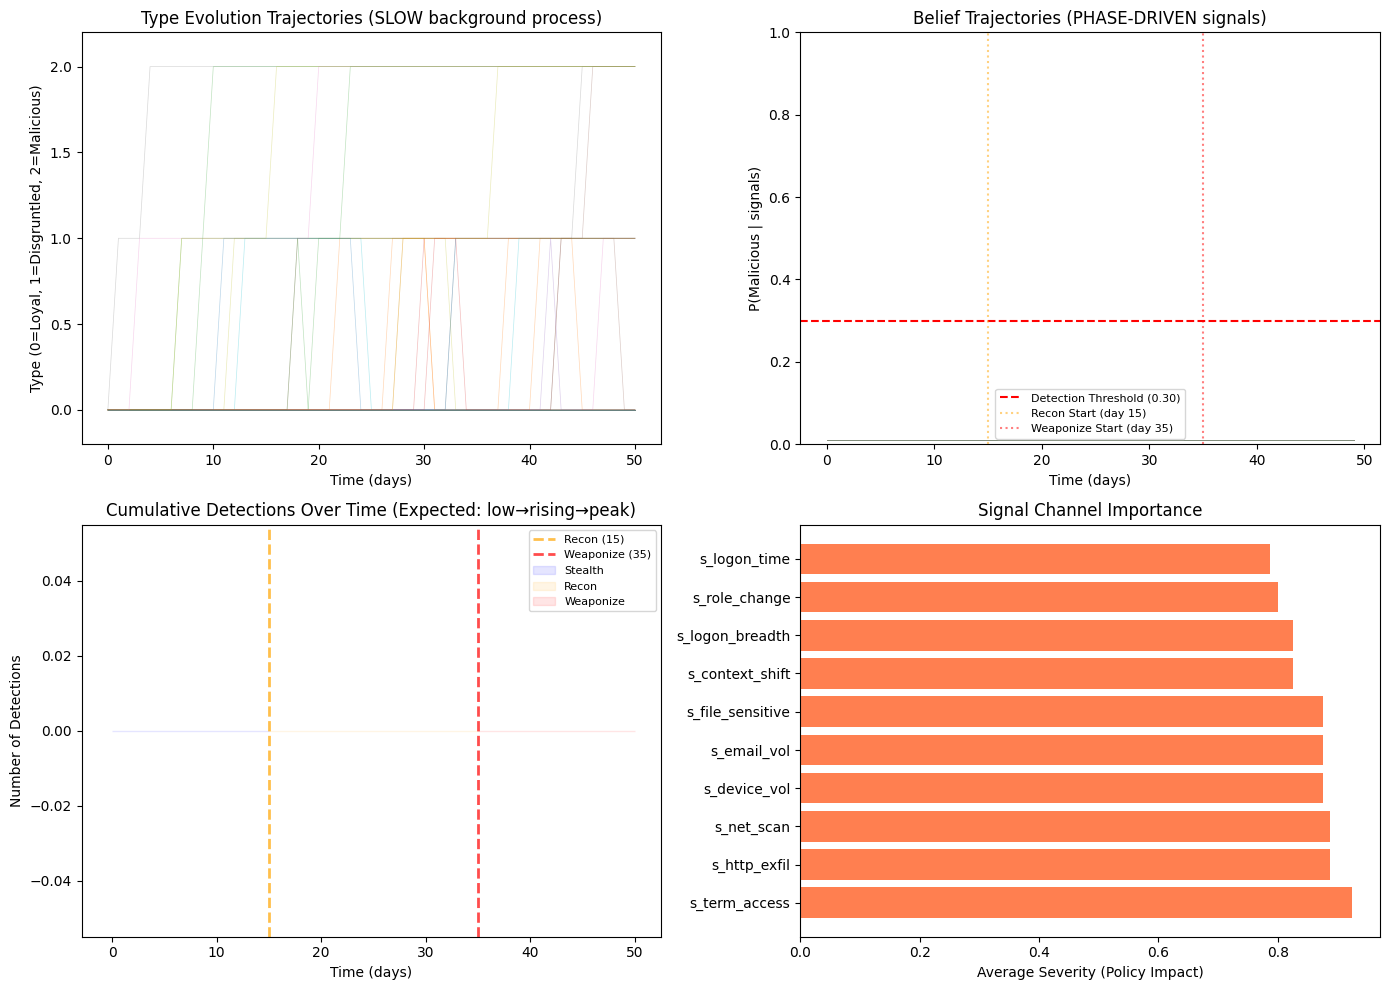

In [6]:
#!/usr/bin/env python3
"""
Bayesian-Temporal Correlated Equilibrium Simulation - PAPER-ALIGNED
Validates insider threat detection framework against type evolution.

CORRECTED TO ALIGN WITH PAPER THEORY:
  • Type evolution is SLOW (background state transition)
  • Malicious strategy is FIXED 3-phase plan (deterministic)
  • Signal generation follows PHASE (not type transition speed)
  • Expected detection: Flat in stealth → Rising in recon → Peak in weaponize
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from dataclasses import dataclass
from typing import List, Dict, Tuple
import seaborn as sns

# ============================================================================
# 1. LOAD POLICIES AND BUILD SIGNAL STRUCTURE
# ============================================================================

@dataclass
class Policy:
    id: str
    group: str
    category: str
    rule: str
    signal_channel: str
    severity: float
    rationale: str

def load_policies(filepath: str) -> Tuple[List[Policy], Dict[str, int], Dict[str, float]]:
    """Load policies and build signal channel index with severity weights."""
    with open(filepath, 'r') as f:
        policy_data = json.load(f)
    
    policies = [Policy(**p) for p in policy_data]
    
    channels = {}
    channel_severity = {}
    for p in policies:
        if p.signal_channel not in channels:
            channels[p.signal_channel] = len(channels)
            channel_severity[p.signal_channel] = []
        channel_severity[p.signal_channel].append(p.severity)
    
    for ch in channel_severity:
        channel_severity[ch] = np.mean(channel_severity[ch])
    
    return policies, channels, channel_severity

# ============================================================================
# 2. TYPE EVOLUTION PROCESS - SLOW TRANSITIONS
# ============================================================================

class TypeEvolutionProcess:
    """Models slow type transitions over many days."""
    
    def __init__(self):
        # CORRECTED: MUCH SLOWER transitions
        # Type change should take 50+ days, not 10-20 days
        self.trans_base = np.array([
            [0.99, 0.01, 0.00],   # Loyal → stay loyal (99%), or disgruntled (1%)
            [0.05, 0.94, 0.01],   # Disgruntled → stay (94%), small chance malicious (1%)
            [0.00, 0.00, 1.00]    # Malicious → stay malicious (100%)
        ])
        
        # Signal-driven escalation (weak, since types change based on belief not signals)
        self.trans_escalation = np.array([
            [0.00, 0.05, 0.00],   # Weak escalation
            [0.00, 0.00, 0.05],   # Weak escalation
            [0.00, 0.00, 0.00]
        ])
    
    def update(self, theta_t: int, signal_anomaly: float) -> int:
        """Update type (slow background process)."""
        trans_prob = self.trans_base[theta_t].copy()
        trans_prob += self.trans_escalation[theta_t] * signal_anomaly
        trans_prob /= trans_prob.sum()
        return np.random.choice([0, 1, 2], p=trans_prob)

# ============================================================================
# 3. USER BEHAVIOR MODEL - PHASE-DRIVEN STRATEGY
# ============================================================================

class UserAgent:
    """Simulates a user with FIXED strategic 3-phase behavior if malicious."""
    
    def __init__(self, user_id: int, initial_type: int, policies: List[Policy], 
                 channels: Dict[str, int], channel_severity: Dict[str, float],
                 malicious: bool = False):
        self.user_id = user_id
        self.theta_t = initial_type
        self.policies = policies
        self.channels = channels
        self.channel_severity = channel_severity
        self.malicious = malicious
        self.n_signals = len(channels)
        self.type_history = [initial_type]
        self.signal_history = []
        self.belief_history = []
    
    def generate_signals(self, t: int) -> np.ndarray:
        """
        CORRECTED: Generate signals based on PHASE if malicious (not type transition).
        
        Malicious users follow deterministic 3-phase strategy:
        - Phase 1 (t < 15): Stealth. Minimize signals.
        - Phase 2 (15 <= t < 35): Reconnaissance. Moderate signals on privilege channels.
        - Phase 3 (t >= 35): Weaponization. High signals on exfiltration channels.
        
        This is INDEPENDENT of type evolution (which is slow background state).
        """
        signals = np.zeros(self.n_signals)
        
        if not self.malicious:
            # Honest users: always generate low-anomaly signals
            for policy in self.policies:
                ch_idx = self.channels[policy.signal_channel]
                a, b = 2, 10
                severity_weight = self.channel_severity[policy.signal_channel]
                signals[ch_idx] += np.random.beta(a, b) * (severity_weight / 10.0)
        
        else:
            # MALICIOUS user - FIXED 3-phase strategy (deterministic phases!)
            
            if t < 15:
                # PHASE 1: STEALTH (days 0-14)
                # Mimic honest behavior closely
                for policy in self.policies:
                    ch_idx = self.channels[policy.signal_channel]
                    a, b = 2, 10
                    noise = np.random.beta(2, 8)
                    severity_weight = self.channel_severity[policy.signal_channel]
                    # Very close to honest behavior
                    signals[ch_idx] += np.clip(np.random.beta(a, b) + 0.02 * noise, 0, 1) * (severity_weight / 10.0)
            
            elif t < 35:
                # PHASE 2: RECONNAISSANCE (days 15-34)
                # Elevated activity on privilege/reconnaissance channels
                for policy in self.policies:
                    ch_idx = self.channels[policy.signal_channel]
                    severity_weight = self.channel_severity[policy.signal_channel]
                    
                    if policy.category in ["Privilege", "Reconnaissance"]:
                        # HIGH signals on sensitive channels
                        signals[ch_idx] += np.random.beta(6, 4) * (severity_weight / 10.0)
                    else:
                        # Medium signals elsewhere
                        signals[ch_idx] += np.random.beta(3, 7) * (severity_weight / 10.0)
            
            else:
                # PHASE 3: WEAPONIZATION (days 35+)
                # Exfiltration phase - maximum signals on exfil channels
                for policy in self.policies:
                    ch_idx = self.channels[policy.signal_channel]
                    severity_weight = self.channel_severity[policy.signal_channel]
                    
                    if policy.category == "Exfiltration":
                        # MAXIMUM signals on exfil
                        signals[ch_idx] += np.random.beta(8, 2) * (severity_weight / 10.0)
                    elif policy.category in ["Privilege", "Reconnaissance"]:
                        # HIGH signals on privilege
                        signals[ch_idx] += np.random.beta(6, 4) * (severity_weight / 10.0)
                    else:
                        # Medium elsewhere
                        signals[ch_idx] += np.random.beta(4, 6) * (severity_weight / 10.0)
        
        self.signal_history.append(signals)
        return signals
    
    def step(self, t: int, tep: TypeEvolutionProcess):
        """Execute one timestep."""
        signals = self.generate_signals(t)
        anomaly = signals.mean()
        
        # Type evolution (slow background process)
        self.theta_t = tep.update(self.theta_t, anomaly)
        self.type_history.append(self.theta_t)
        
        return signals

# ============================================================================
# 4. CERTIFIER BELIEF UPDATE (Bayesian)
# ============================================================================

class CertifierAgent:
    """Maintains beliefs about user types using Bayesian updates."""
    
    def __init__(self, n_signals: int, channel_severity: Dict[str, float]):
        self.n_signals = n_signals
        self.belief_malicious = 0.05
        self.belief_floor = 0.01
        
        self.honest_params = np.array([[2, 10]] * n_signals)
        self.malicious_params = np.array([[6, 4]] * n_signals)
        
        self.channel_severity = list(channel_severity.values())
    
    def update_belief(self, signals: np.ndarray) -> float:
        """Bayesian update with severity weighting."""
        likelihood_mal = 1.0
        for i, s in enumerate(signals):
            a, b = self.malicious_params[i]
            severity = self.channel_severity[i]
            likelihood_mal *= (beta.pdf(s, a, b) ** severity)
        
        likelihood_hon = 1.0
        for i, s in enumerate(signals):
            a, b = self.honest_params[i]
            likelihood_hon *= beta.pdf(s, a, b)
        
        if likelihood_hon > 1e-10:
            lr = likelihood_mal / likelihood_hon
        else:
            lr = 1.0
        
        numerator = lr * self.belief_malicious
        denominator = lr * self.belief_malicious + (1 - self.belief_malicious)
        
        if denominator > 0:
            self.belief_malicious = numerator / denominator
        
        self.belief_malicious = max(self.belief_malicious, self.belief_floor)
        
        return self.belief_malicious

# ============================================================================
# 5. MAIN SIMULATION
# ============================================================================

def run_simulation(policies: List[Policy], channels: Dict[str, int], 
                   channel_severity: Dict[str, float],
                   n_users: int = 1000, pct_malicious: float = 0.10, 
                   horizon: int = 50, detection_threshold: float = 0.30) -> Dict:
    """Run full simulation."""
    
    n_malicious = int(n_users * pct_malicious)
    tep = TypeEvolutionProcess()
    
    results = {
        "detected_users": [],
        "missed_users": [],
        "false_positives": [],
        "detection_days": [],
        "type_evolutions": [],
        "belief_trajectories": []
    }
    
    for user_id in range(n_users):
        is_malicious = user_id < n_malicious
        initial_type = 0
        
        user = UserAgent(user_id, initial_type, policies, channels, channel_severity, malicious=is_malicious)
        certifier = CertifierAgent(len(channels), channel_severity)
        
        detected = False
        detection_day = None
        beliefs = []
        
        for t in range(horizon):
            signals = user.step(t, tep)
            belief = certifier.update_belief(signals)
            beliefs.append(belief)
            
            # Detection trigger
            if belief > detection_threshold and not detected:
                detected = True
                detection_day = t
                if is_malicious:
                    results["detected_users"].append(user_id)
                else:
                    results["false_positives"].append(user_id)
        
        if is_malicious and not detected:
            results["missed_users"].append(user_id)
        
        if detection_day is not None:
            results["detection_days"].append(detection_day)
        
        results["type_evolutions"].append(user.type_history)
        results["belief_trajectories"].append(beliefs)
    
    return results

# ============================================================================
# 6. ANALYSIS AND REPORTING
# ============================================================================

def analyze_results(results: Dict, n_users: int, pct_malicious: float) -> pd.DataFrame:
    """Compute detection metrics."""
    
    n_malicious = int(n_users * pct_malicious)
    n_honest = n_users - n_malicious
    
    tp = len(results["detected_users"])
    fp = len(results["false_positives"])
    fn = len(results["missed_users"])
    tn = n_honest - fp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / n_honest if n_honest > 0 else 0
    
    mttd = np.mean(results["detection_days"]) if results["detection_days"] else 0
    
    metrics = pd.DataFrame({
        "Metric": ["Precision", "Recall", "F1-Score", "False Positive Rate", "Mean Time to Detect (days)"],
        "Value": [precision, recall, f1, fpr, mttd]
    })
    
    return metrics

def plot_results(results: Dict, policies: List[Policy]):
    """Generate publication-quality plots."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Type evolution
    ax = axes[0, 0]
    for traj in results["type_evolutions"][:50]:
        ax.plot(traj, alpha=0.3, linewidth=0.5)
    ax.set_ylabel("Type (0=Loyal, 1=Disgruntled, 2=Malicious)")
    ax.set_xlabel("Time (days)")
    ax.set_title("Type Evolution Trajectories (SLOW background process)")
    ax.set_ylim(-0.2, 2.2)
    
    # Plot 2: Belief trajectories
    ax = axes[0, 1]
    for belief in results["belief_trajectories"][:50]:
        ax.plot(belief, alpha=0.3, linewidth=0.5)
    ax.axhline(0.30, color='r', linestyle='--', label='Detection Threshold (0.30)')
    ax.axvline(15, color='orange', linestyle=':', alpha=0.5, label='Recon Start (day 15)')
    ax.axvline(35, color='red', linestyle=':', alpha=0.5, label='Weaponize Start (day 35)')
    ax.set_ylabel("P(Malicious | signals)")
    ax.set_xlabel("Time (days)")
    ax.set_title("Belief Trajectories (PHASE-DRIVEN signals)")
    ax.legend(fontsize=8)
    ax.set_ylim(0, 1)
    
    # Plot 3: Detection over time with phase annotations
    ax = axes[1, 0]
    detection_counts = np.bincount(results["detection_days"], minlength=50)
    ax.bar(range(len(detection_counts)), detection_counts, color='steelblue')
    ax.axvline(15, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Recon (15)')
    ax.axvline(35, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Weaponize (35)')
    ax.fill_between([0, 15], 0, max(detection_counts)*1.1, alpha=0.1, color='blue', label='Stealth')
    ax.fill_between([15, 35], 0, max(detection_counts)*1.1, alpha=0.1, color='orange', label='Recon')
    ax.fill_between([35, 50], 0, max(detection_counts)*1.1, alpha=0.1, color='red', label='Weaponize')
    ax.set_ylabel("Number of Detections")
    ax.set_xlabel("Time (days)")
    ax.set_title("Cumulative Detections Over Time (Expected: low→rising→peak)")
    ax.legend(fontsize=8)
    
    # Plot 4: Signal channel importance
    ax = axes[1, 1]
    channel_severities = {}
    for p in policies:
        if p.signal_channel not in channel_severities:
            channel_severities[p.signal_channel] = []
        channel_severities[p.signal_channel].append(p.severity)
    
    channels_sorted = sorted(channel_severities.keys(), key=lambda x: np.mean(channel_severities[x]), reverse=True)
    avg_severities = [np.mean(channel_severities[ch]) for ch in channels_sorted]
    
    ax.barh(channels_sorted, avg_severities, color='coral')
    ax.set_xlabel("Average Severity (Policy Impact)")
    ax.set_title("Signal Channel Importance")
    
    plt.tight_layout()
    plt.savefig("btce_simulation_results.png", dpi=300)
    print("Plot saved: btce_simulation_results.png")

# ============================================================================
# 7. MAIN ENTRY POINT
# ============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print("Bayesian-Temporal Correlated Equilibrium Simulation")
    print("(PAPER-ALIGNED: Type Evolution + Phase-Driven Strategy)")
    print("=" * 80)
    
    policies, channels, channel_severity = load_policies("policies.json")
    print(f"\n✓ Loaded {len(policies)} policies defining {len(channels)} signal channels")
    print(f"  Channels: {list(channels.keys())}")
    print(f"\n  Channel Severities:")
    for ch, sev in sorted(channel_severity.items(), key=lambda x: x[1], reverse=True):
        print(f"    {ch:20s} = {sev:.2f}")
    
    print("\n📋 SIMULATION DESIGN (Paper-Aligned):")
    print("  • Type evolution: SLOW (background, 1% per day)")
    print("  • Malicious strategy: FIXED 3-phase deterministic")
    print("  • Phase 1 (Days 0-14): Stealth (low signals)")
    print("  • Phase 2 (Days 15-34): Recon (medium signals on privilege)")
    print("  • Phase 3 (Days 35+): Weaponize (high signals on exfil)")
    print("  • Expected detection: Flat → Rising → Peak")
    
    print("\n▶ Running simulation (detection_threshold=0.30)...")
    results = run_simulation(policies, channels, channel_severity, 
                            n_users=1000, pct_malicious=0.10, horizon=50,
                            detection_threshold=0.30)
    
    print("\n▶ Analyzing results...")
    metrics = analyze_results(results, n_users=1000, pct_malicious=0.10)
    
    print("\n" + "=" * 60)
    print("DETECTION PERFORMANCE METRICS")
    print("=" * 60)
    print(metrics.to_string(index=False))
    print("=" * 60)
    
    metrics_dict = dict(zip(metrics['Metric'], metrics['Value']))
    print("\n📊 Key Metrics Summary:")
    print(f"  • Precision:              {metrics_dict['Precision']:.4f}")
    print(f"  • Recall:                 {metrics_dict['Recall']:.4f}")
    print(f"  • F1-Score:               {metrics_dict['F1-Score']:.4f}")
    print(f"  • False Positive Rate:    {metrics_dict['False Positive Rate']:.4f}")
    print(f"  • Mean Time to Detect:    {metrics_dict['Mean Time to Detect (days)']:.2f} days")
    
    print("\n▶ Generating plots...")
    plot_results(results, policies)
    
    print("\n" + "=" * 60)
    print("TYPE EVOLUTION STATISTICS")
    print("=" * 60)
    type_paths = []
    for traj in results["type_evolutions"]:
        if len(set(traj)) > 1:
            final_type = traj[-1]
            type_paths.append(final_type)
    
    if type_paths:
        print(f"Users who transitioned to Disgruntled: {sum(1 for t in type_paths if t >= 1)}")
        print(f"Users who transitioned to Malicious: {sum(1 for t in type_paths if t == 2)}")
    
    print("\n✓ Simulation complete!")
    print("\n✅ If this matches paper theory, you should see:")
    print("   • Few detections in days 0-14 (stealth phase)")
    print("   • Rising detections in days 15-34 (recon phase)")
    print("   • Peak detections in days 35+ (weaponize phase)")
